# Data preparation

In [1]:
from lib import *

0        0
1        1
2        0
3        0
4        1
        ..
43195    1
43196    2
43197    2
43198    0
43199    2
Name: Avg. Readers_Joy, Length: 43200, dtype: int64
0        [0, 2, 0, 0, 0, 0, 0, 0]
1        [1, 0, 0, 2, 0, 0, 0, 0]
2        [0, 0, 0, 1, 0, 0, 0, 0]
3        [0, 1, 0, 0, 0, 0, 1, 0]
4        [1, 0, 0, 1, 0, 0, 0, 0]
                   ...           
43195    [1, 0, 0, 1, 0, 0, 0, 0]
43196    [2, 0, 2, 0, 0, 0, 0, 0]
43197    [2, 0, 0, 0, 0, 0, 0, 0]
43198    [0, 0, 2, 0, 0, 0, 0, 0]
43199    [2, 0, 0, 0, 0, 0, 0, 1]
Name: readers_emotion_intensities, Length: 43200, dtype: object


In [2]:
# reindex
df_wrime_target = df_wrime_target.reset_index(drop=True)
# df_wrime_target.info()

In [3]:
sentences = df_wrime_target['Sentence'].tolist()

# replace '\n' with ''
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# replace 'x000D' with ''
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

# Prepare embeddings of tweets based on emotional intensities. 

In [4]:
flag = "word2vec" #  "pretrained" # "fine_tuned" # or  or 

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Load pretrained model/tokenizer. 
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking' # 'cl-tohoku/bert-base-japanese-v2'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

embedding_path = "output"
if not os.path.isdir(embedding_path):
    os.makedirs(embedding_path)

if flag == "pretrained":
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, output_hidden_states=True) # output_hidden_states=True allows us to access hidden states. 
    path_to_embeddings = os.path.join(embedding_path, 'pretrained_embeddings.tsv')

elif flag == "fine_tuned":
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join("output", "trained_model"), output_hidden_states=True) # output_hidden_states=True allows us to access hidden states.
    path_to_embeddings = os.path.join(embedding_path, 'fine-tuned_embeddings.tsv')

elif flag == "word2vec":
    path_to_embeddings = os.path.join(embedding_path, 'word2vec_embeddings.tsv')

permutation_for_cluster_IDs = map_of_permutation_for_cluster_IDs[flag]

if os.path.isfile(path_to_embeddings):
    df_embeddings = pd.read_table(path_to_embeddings, header=None)
else:
    if flag == "word2vec":
        df_embeddings = make_embeddings_by_word2vec(sentences, path_to_embeddings)
    else:
        df_embeddings = make_embeddings_by_bert(sentences, tokenizer, model, path_to_embeddings)

/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

# K-means clustering by embeddings. 

In [6]:
from sklearn.cluster import KMeans

k = 6 # number of clusters
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)

# Cluster ID (0-based) for each tweet. 
clusters = kmeansModel.labels_
# Cluster ID is 1-based. 
clusters = clusters + 1
print(kmeansModel.labels_)
print(len(kmeansModel.labels_))
print(clusters)

/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 0 2 ... 2 0 0]
18237
[3 1 3 ... 3 1 1]


In [7]:
# Load the intensity-based clusters
_df = pd.read_csv(os.path.join('output', 'emotion_6_clusters.tsv'), sep='\t', header=None)
# emotion_clusters = _df[0].tolist()
# emotion_clusters = [int(x) for x in emotion_clusters]
emotion_clusters = [int(x) for x in _df[0].tolist()]
df_intensity_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])
df_intensity_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


## Comparison of the pretrain model embedding-based clusters with the intensity-based clusters. 

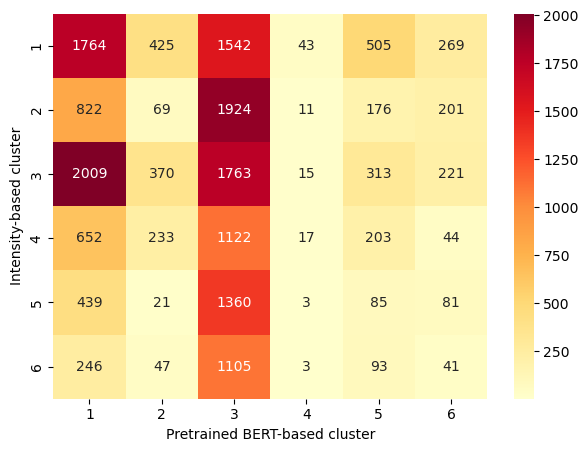

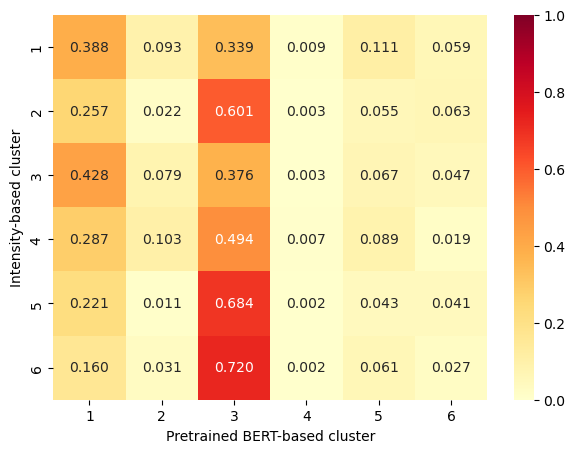

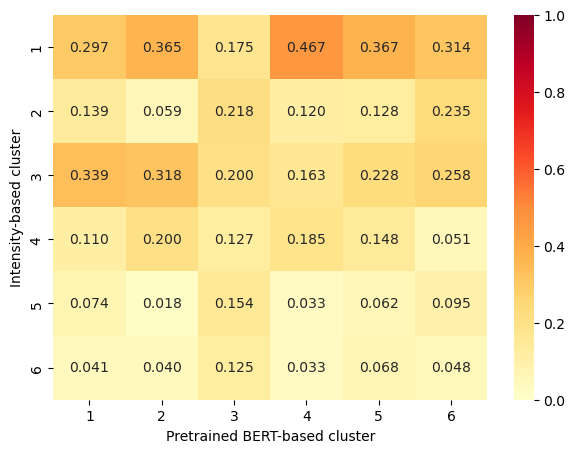

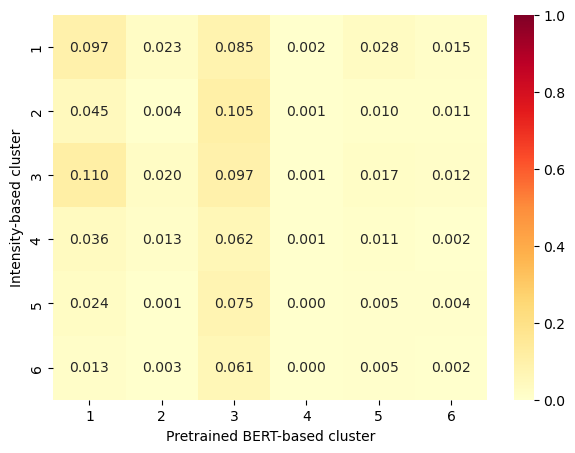

In [8]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])
conf_mat = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters))) # confusion matrix
# conf_mat_norm_by_row = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row. 
# conf_mat_norm_by_column = conf_mat.astype('float') / conf_mat.sum(axis=0)[:, np.newaxis] # Normalize the confusion matrix by row. 

conf_mat_norm_by_row = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)), normalize='true') 
conf_mat_norm_by_column = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)), normalize='pred') 
conf_mat_norm_by_all = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)), normalize='all') 

# Heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_row, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_column, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_all, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()


In [9]:
indexes = range(1,len(permutation_for_cluster_IDs)+1)
for index, val in zip(indexes, permutation_for_cluster_IDs):
    clusters[clusters == index] = -val

for id in range(1,7):
    clusters[clusters == -id] = id
print(clusters)

[5 3 5 ... 5 3 3]


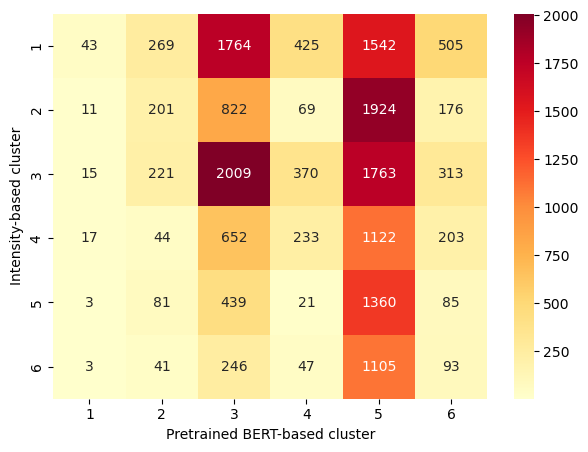

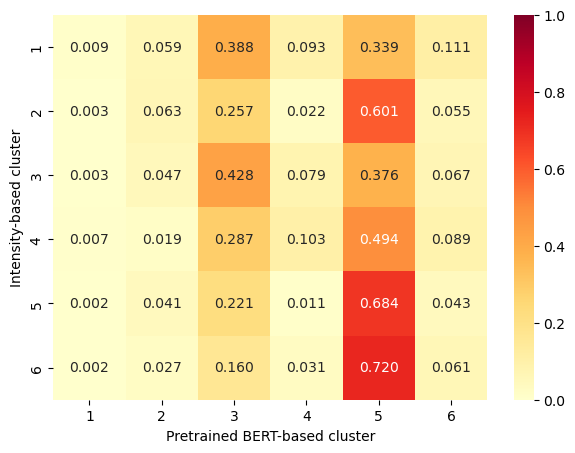

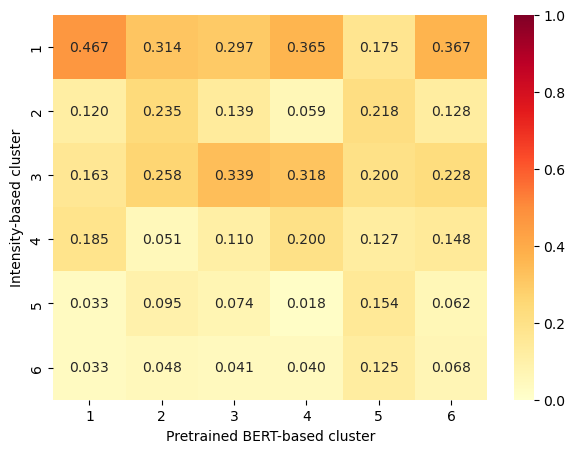

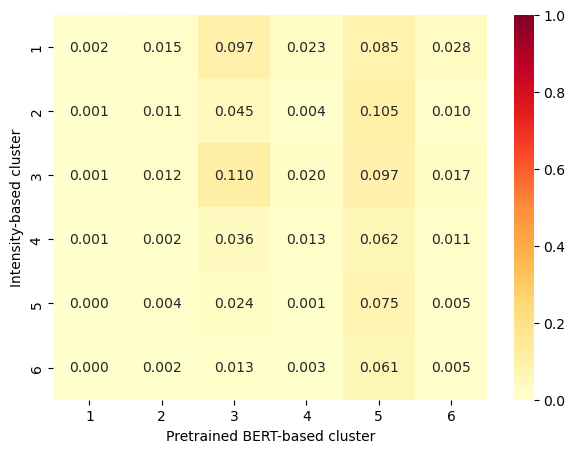

In [10]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])
conf_mat = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters))) # confusion matrix
# conf_mat_norm_by_row = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row. 
# conf_mat_norm_by_column = conf_mat.astype('float') / conf_mat.sum(axis=0)[:, np.newaxis] # Normalize the confusion matrix by row. 

conf_mat_norm_by_row = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)), normalize='true') 
conf_mat_norm_by_column = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)), normalize='pred') 
conf_mat_norm_by_all = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)), normalize='all') 

# Heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_row, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_column, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_all, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()


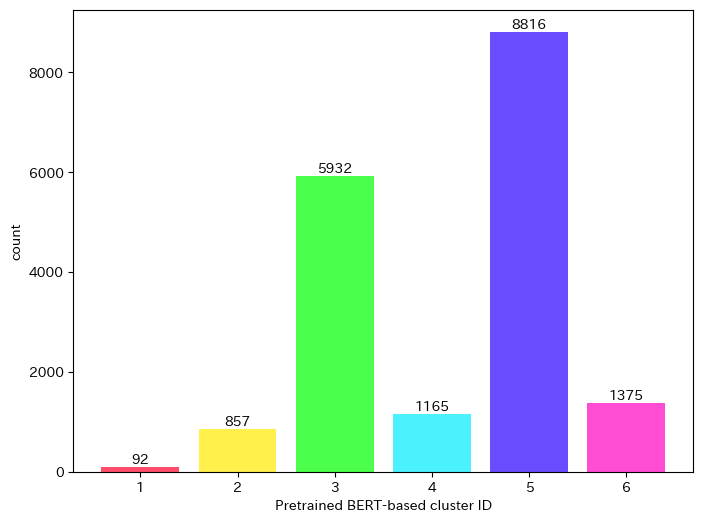

In [11]:
# setting Japanese font
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# frequency of each cluster
cluster_IDs, counts = np.unique(clusters, return_counts=True) # cluster_IDs = [1, 2, 3, 4, 5, 6]

colors = cmap(np.linspace(0, 1, len(cluster_IDs)))

plt.figure(figsize=(8, 6))
bars = plt.bar(cluster_IDs, counts, color=colors, alpha=0.7)
plt.xlabel('Pretrained BERT-based cluster ID')
plt.ylabel('count')
# plt.title(f'Size of Pretrained BERT-based clusters')
plt.xticks(cluster_IDs)

# Display texts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

In [12]:
# Similarity between tweets.

from sklearn.metrics.pairwise import cosine_similarity

target_index = 1 # find similar sentences to this sentence.

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

index: 1
Tweet: 今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
Similarity = 0.9999999999999998
---
index: 13953
Tweet: 今日も友人と遊んできたのですが､やっぱり休職してるとは､とてもじゃないけど言えないなあと思ってしまいました｡友人が信じられないからとかではなく､やっぱり自分が世間体を気にしてしまっている｡まあ自分から進んで言うような事でもないけど｡難しい｡
Similarity = 0.7188384283279367
---
index: 16504
Tweet: 昨日の夜、会社の体質（というか上司の質）が悲しくて帰り道で泣いた！！みんなで夜中に歌ったりラーメン食べたり楽しかった一年前に戻りたいよ、、、\n\nどうか先輩が今日も明日も、\nたくさんたくさん眠って\nいい夢を見ていますように。
Similarity = 0.694370316837933
---
index: 13947
Tweet: noteを書くのは楽しい｡ストレスを全く感じず､時間を忘れて取り組める｡自分の思ったことをまとめる事が好きなのかもしれないという気づき｡
Similarity = 0.6921135618682792
---
index: 10859
Tweet: 無常
Similarity = -0.05604844095608205
---
index: 5007
Tweet: ﾌｧｯｷﾝﾎｯﾄ
Similarity = -0.0481576280597328
---
index: 10339
Tweet: じしん 
Similarity = -0.04515578850269569
---


Plots:
PCA label= generated embeddings cluster IDs (GECI)
PCA label= emotion intensity-based cluster IDs (EICI)
t-SNE label= GECI
t-SNE label= EICI
UMAP label= GECI
UMAP label= EICI

/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/umap/dist

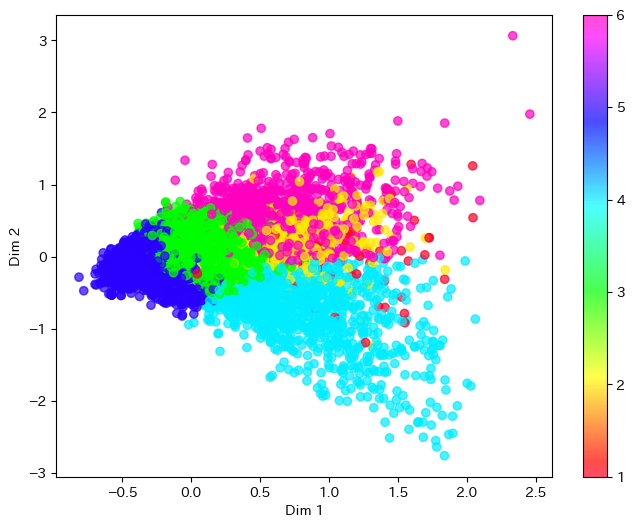

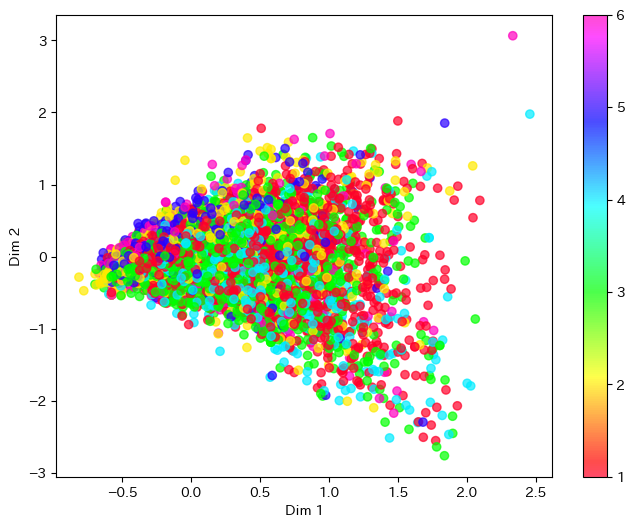

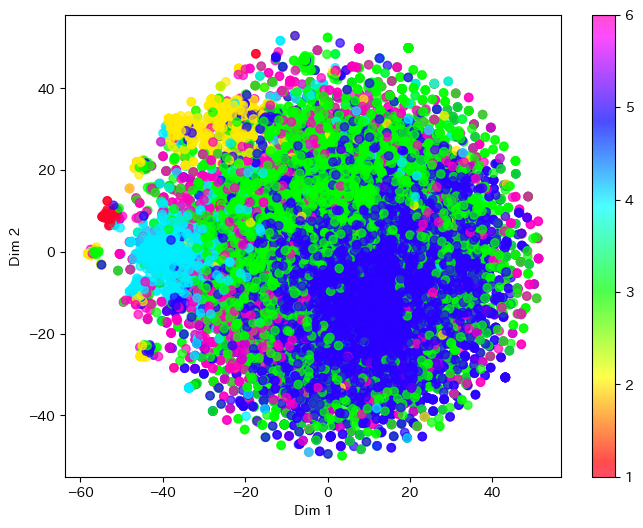

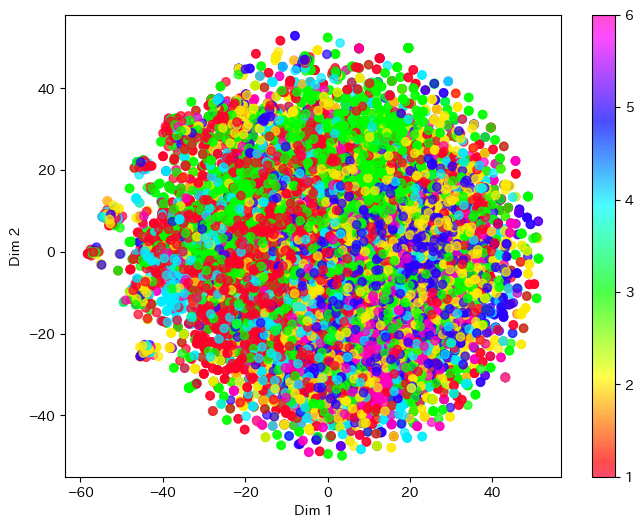

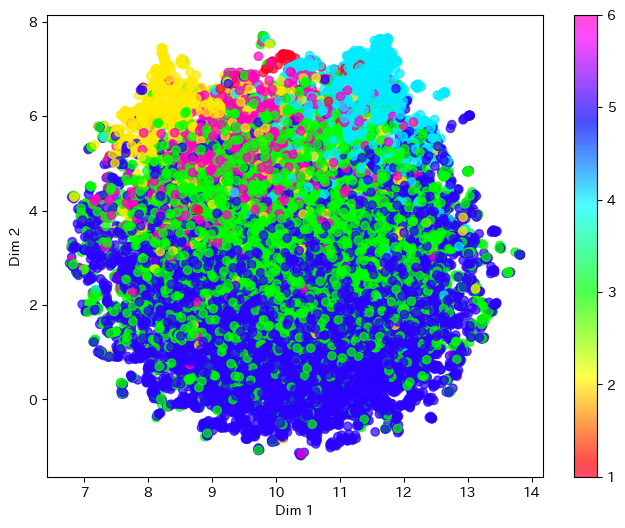

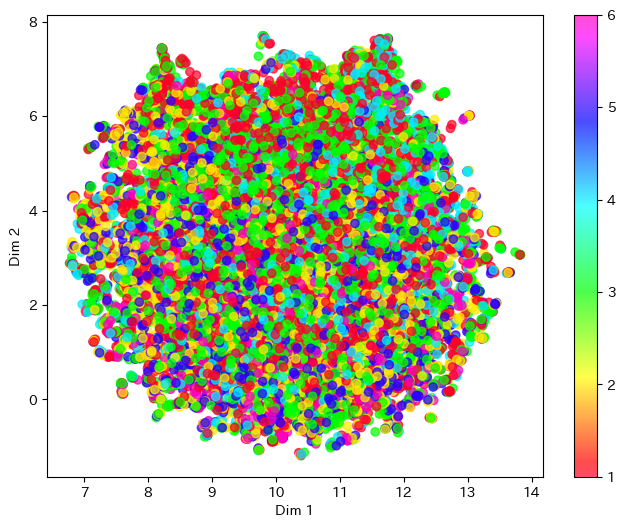

In [13]:
df_wrime_features_pca, df_wrime_features_tsne, df_wrime_features_umap = appy_dimensionality_reduction(df_embeddings, clusters, emotion_clusters)

# Finding the optimal cluster size

In [16]:
k_max=41

In [17]:
'''
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\n\n# Survey of optimal number of clusters by Elbow Method\nSSE = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeans_model.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), SSE, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('SSE')\nplt.title('Survey of optimal number of clusters by Elbow Method')\nplt.grid(True)\nplt.show()\n"

In [18]:
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\n\n# Survey of optimal number of clusters by Silhouette Coefficient\nsilhouette_coefficients = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('Silhouette Coefficient')\nplt.title('Survey of optimal number of clusters by Silhouette Coefficient')\nplt.grid(True)\nplt.show()\n"

### Plot showing silhouette scores

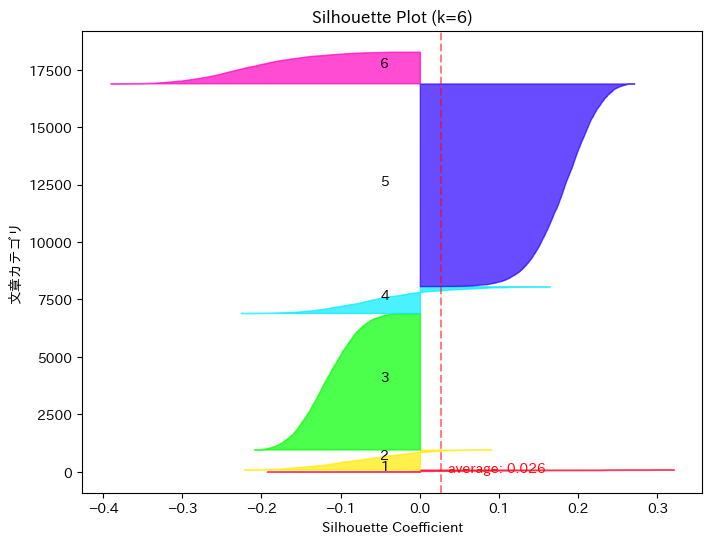

In [19]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('文章カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [20]:
# The tweet with the highest silhouette coefficient in each intensity-based cluster
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')

Intensity-based cluster ID: 1
The highest scored tweet: ジョジョはじまったあああああああああああああああ
Silhouette score: 0.321
---
Intensity-based cluster ID: 2
The highest scored tweet: 女装たのしみ?? ( ?ω? Ξ ?ω? ) ??
Silhouette score: 0.091
---
Intensity-based cluster ID: 3
The highest scored tweet: やっと夏休み
Silhouette score: -0.016
---
Intensity-based cluster ID: 4
The highest scored tweet: 閣下！！！！！
Silhouette score: 0.164
---
Intensity-based cluster ID: 5
The highest scored tweet: ひとりになりたいだろうと思って早めに帰ったけどそれは私の勝手な想像で、もしかしたら誰でもいいから側に居て欲しかったのかもしれない。本当の本当は思いやりなんかじゃなくて、泣かれたりしたらどうしようって思って、そんな姿を見て自分が傷つくのが嫌で逃げ帰ったんだよ。
Silhouette score: 0.271
---
Intensity-based cluster ID: 6
The highest scored tweet: こわ
Silhouette score: -0.032
---


In [21]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 5
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    # print(f'文章カテゴリ: {clusters[index]}')
    # print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    # print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    # print('---')

    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')



Intensity-based cluster ID: 5
The highest scored tweet: ひとりになりたいだろうと思って早めに帰ったけどそれは私の勝手な想像で、もしかしたら誰でもいいから側に居て欲しかったのかもしれない。本当の本当は思いやりなんかじゃなくて、泣かれたりしたらどうしようって思って、そんな姿を見て自分が傷つくのが嫌で逃げ帰ったんだよ。
Silhouette score: 0.271
---
Intensity-based cluster ID: 5
The highest scored tweet: これ何回か言ってるけど私もすごい不良債権だと思うんですよ、それでも気にしないとかそこがいいとか言ってくれる人がいるのはほんとにありがたくて幸せなことだなと思いますね… 昨日TLで見た｢必要な時に必要な人が現れる｣ってやつなのかなぁ
Silhouette score: 0.271
---
Intensity-based cluster ID: 5
The highest scored tweet: 我が道を行きすぎて視野が狭くなるのもどうかと思うのです。って、人に対して思うくせに、実は私が人に言われるんです。「あなたって自分の考えに固執してるよね（要約）」と。うーん、そう言ってくる人も人のこと言えないと思うんだけどなぁ。好きなもの、好きな見方ばっかり集めて言われてもナ。\n\n
Silhouette score: 0.271
---
Intensity-based cluster ID: 5
The highest scored tweet: 110）おい上は自分が持ってる武器で何をするのが一番いいだろう、ってあれからずっと考えてる。それが「あのとき何をしたか」を共有して、おい上だけのものにしないことだと思った。だから話すことにした。\n情報発信はスキルだ。それを少しでも多くの人に身につけてもらったら、いざというときに→
Silhouette score: 0.271
---
Intensity-based cluster ID: 5
The highest scored tweet: 思い悩めるほどの余裕があるということか。そうだな。子どもも、もうずっと見ていないと危険、というわけではない年になったし、最近自分のことばっかり考えてる気が

### From the embeddings of tweets generated by the pretrained BERT model, infer the intensity-based cluster IDs

In [22]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clusters], ignore_index=True, axis=1)
# df_embeddings_clustersの最後の列を1引く
df_embeddings_clusters.iloc[:, -1] = df_embeddings_clusters.iloc[:, -1] - 1

df_embeddings_clusters

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,0.084154,0.016443,0.124722,0.118124,0.119604,-0.012181,-0.063918,0.078760,0.020033,...,-0.037173,0.064539,0.021571,0.019322,0.022682,0.077194,-0.084505,0.008135,-0.021437,1
1,train,0.063521,0.068099,0.206007,0.002981,0.114179,0.018693,-0.068616,0.061156,-0.035621,...,-0.090980,0.085357,-0.008059,-0.070539,0.112158,0.088492,-0.097414,-0.035741,-0.136759,3
2,train,0.054254,0.017880,0.197330,0.051955,0.084180,-0.007447,0.000891,0.015956,0.031242,...,-0.092722,0.059138,-0.044549,0.010693,0.087542,0.084317,-0.046825,-0.035792,0.017837,0
3,train,0.054431,-0.240173,-0.040082,0.386641,0.240335,0.075739,-0.136742,-0.024492,-0.006851,...,0.095406,-0.206100,0.019051,0.046810,0.095603,-0.282606,-0.118548,0.040670,-0.043923,2
4,train,0.072169,-0.041078,0.163900,0.076347,0.132362,0.085343,0.012201,0.081568,-0.005250,...,0.025223,-0.022919,-0.025588,-0.085089,0.087127,0.046937,-0.033381,-0.072000,-0.032977,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,0.044775,0.017903,0.035241,0.103595,0.035372,0.030569,-0.037706,0.144676,-0.124964,...,-0.017015,0.028500,0.038715,0.002826,0.027274,0.130667,-0.028538,0.031502,-0.014652,0
18233,train,0.144865,0.067508,0.024082,0.077327,0.094900,0.051435,0.050123,0.100261,0.016219,...,-0.030130,0.027465,0.003664,-0.094959,0.024585,0.173698,-0.012436,0.025246,-0.000808,2
18234,train,0.125726,-0.013649,0.220992,0.185091,0.064554,0.011318,0.005847,0.053450,-0.049095,...,0.009760,0.112339,-0.004077,0.007528,0.059156,0.107709,0.081637,-0.066331,-0.018917,0
18235,train,0.011827,0.143542,0.077518,0.145836,0.031101,0.037682,-0.015691,0.085310,-0.044574,...,-0.089182,0.084868,-0.067038,0.012824,0.049320,-0.005761,0.057392,-0.024891,0.021232,2


In [23]:
# divide into train and test
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [24]:
import xgboost as xgb

# Make input data to xgboost
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.72755	test-mlogloss:1.70827
[1]	train-mlogloss:1.68843	test-mlogloss:1.65288
[2]	train-mlogloss:1.66157	test-mlogloss:1.61766
[3]	train-mlogloss:1.64108	test-mlogloss:1.59314
[4]	train-mlogloss:1.62445	test-mlogloss:1.57107
[5]	train-mlogloss:1.60981	test-mlogloss:1.55426
[6]	train-mlogloss:1.59637	test-mlogloss:1.53836
[7]	train-mlogloss:1.58393	test-mlogloss:1.52606
[8]	train-mlogloss:1.57251	test-mlogloss:1.52003
[9]	train-mlogloss:1.56190	test-mlogloss:1.50629
[10]	train-mlogloss:1.55190	test-mlogloss:1.49451
[11]	train-mlogloss:1.54224	test-mlogloss:1.48611
[12]	train-mlogloss:1.53307	test-mlogloss:1.47621
[13]	train-mlogloss:1.52417	test-mlogloss:1.46648
[14]	train-mlogloss:1.51563	test-mlogloss:1.45708
[15]	train-mlogloss:1.50759	test-mlogloss:1.45040
[16]	train-mlogloss:1.49985	test-mlogloss:1.44639
[17]	train-mlogloss:1.49240	test-mlogloss:1.44194
[18]	train-mlogloss:1.48517	test-mlogloss:1.43357
[19]	train-mlogloss:1.47810	test-mlogloss:1.42930
[20]	train

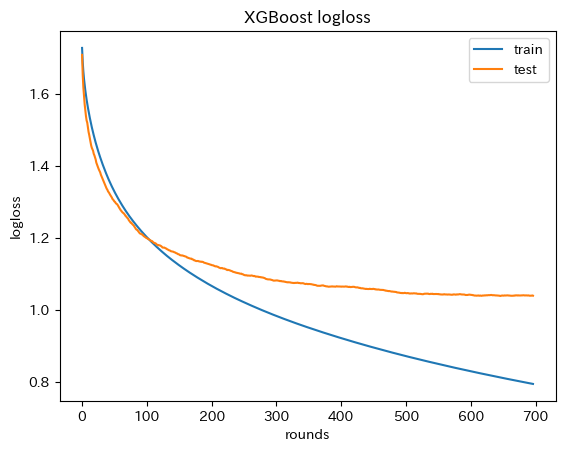

In [25]:
# Model
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.5,
}

history = dict()

# learning
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=50)

# prediciton
preds_labels = model.predict(test_data)

# Visualization
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

In [26]:
test_labels += 1
preds_labels += 1

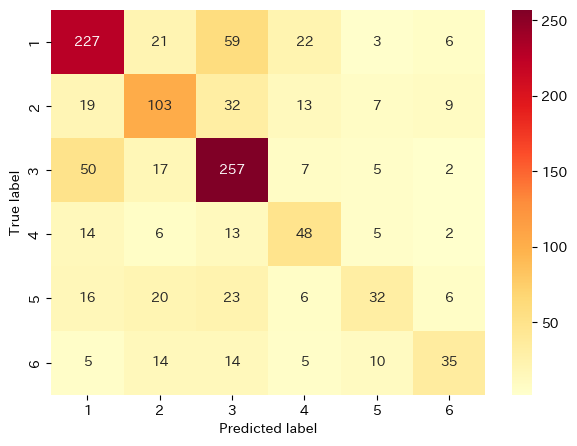

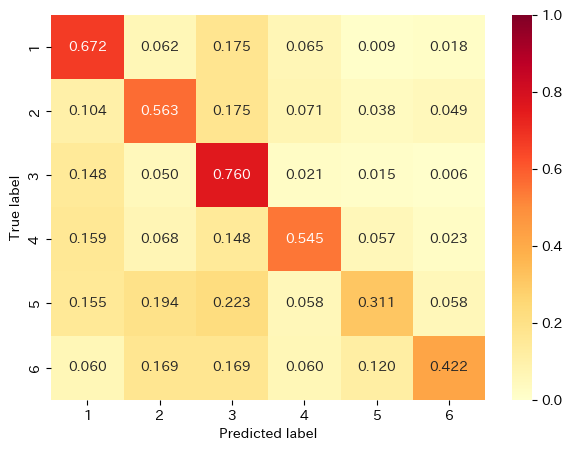

              precision    recall  f1-score   support

           1      0.686     0.672     0.679       338
           2      0.569     0.563     0.566       183
           3      0.646     0.760     0.698       338
           4      0.475     0.545     0.508        88
           5      0.516     0.311     0.388       103
           6      0.583     0.422     0.490        83

    accuracy                          0.620      1133
   macro avg      0.579     0.545     0.555      1133
weighted avg      0.616     0.620     0.613      1133



In [27]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
'cl-tohoku/bert-base-japanese-whole-word-masking' は accuracy 60%  
'cl-tohoku/bert-base-japanese-v2' は accuracy 58.6%

In [28]:
# Indices of false predictions
false_preds = np.where(test_labels != preds_labels)[0]

# Show the first 5 false predictions
for i in false_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

友達がハワイで挙式して、森で撮った写真がすごく素敵で羨ましかった。長い髪はゆる巻きダウンにして、お花の冠とベールをつけてるかんじ。木漏れ日を見上げる姿が可愛かったなぁ。
True label: 1
Predicted label: 3.0
---
似すぎ…笑
True label: 3
Predicted label: 1.0
---
ホットカーペットに寝っ転がってうとうとするのサイコー。
True label: 5
Predicted label: 2.0
---
久しぶりにヤツが来た。ちきしょう、油断してた…コルセット生活、再開!!(T_T)
True label: 5
Predicted label: 3.0
---
ぼくらの思春期を支えたHEY!HEY!HEY!が最終回だよ！懐かしいな～
True label: 3
Predicted label: 1.0
---


---